In [1]:
%load_ext autoreload
%autoreload 2

from flare import trainer
from flare import callbacks

import torch
from torch import nn
from torch import optim as topt
from torch.nn import functional as F

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

Trn 700 / 0.7
Dev 206 / 0.206
Tst 94 / 0.094


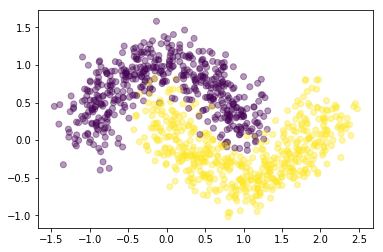

In [2]:
x, y = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=32)
x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, train_size=0.7)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_tst, y_tst, train_size=0.69)

x_trn = torch.from_numpy(x_trn).to(torch.float)
x_dev = torch.from_numpy(x_dev).to(torch.float)
y_trn = torch.from_numpy(y_trn).to(torch.long)
y_dev = torch.from_numpy(y_dev).to(torch.long)

print('Trn {} / {}'.format(len(x_trn), len(x_trn) / len(x)))
print('Dev {} / {}'.format(len(x_dev), len(x_dev) / len(x)))
print('Tst {} / {}'.format(len(x_tst), len(x_tst) / len(x)))

plt.scatter(*x.T, c=y, alpha=0.4)
plt.show()

In [3]:
class SimpleNet(nn.Module):
    def __init__(self, n_fts, n_classes, hidden1=10, hidden2=5):
        super().__init__()
        self.fc1 = nn.Linear(n_fts, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, n_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    @staticmethod
    def metric(prediction: torch.Tensor, y_true: torch.Tensor) -> dict:
        y_hat = prediction.argmax(-1)
        acc = (y_hat == y_true).sum().item()
        return {'accuracy': acc}

In [4]:
from pathlib import Path
import numpy as np

from opytimizer import Opytimizer
from opytimizer.core.function import Function
from opytimizer.spaces.search import SearchSpace
from opytimizer.core.function import Function
from opytimizer.optimizers.fa import FA

METAHEURISTIC = 'firefly'
DEST_FOLDER = Path('./trained/')
callno = 0

def fun(x: np.ndarray):
    global callno

    hidden1 = int(np.round(x[0][0]))
    hidden2 = int(np.round(x[1][0]))
    lr = x[2][0]
    
    model_name = f'{METAHEURISTIC}_{callno}'
    filename = str(DEST_FOLDER / model_name)

    cbs = [
        callbacks.Checkpoint('val_accuracy', min_delta=1e-3, filename=filename, save_best=True, increasing=True)
    ]

    model = SimpleNet(n_fts=2, n_classes=2, hidden1=hidden1, hidden2=hidden2)
    loss_fn = F.cross_entropy
    nn_optimizer = topt.SGD(model.parameters(), lr=lr)
    
    history = trainer.train(model, x_trn, y_trn, loss_fn, nn_optimizer,
                            n_epochs=15, batch_size=32, x_val=x_dev, y_val=y_dev,
                            batch_first=True, callbacks=cbs, verbosity=1)
    
    best_model = torch.load(filename + '.pth')
    eval_metrics = trainer.evaluate(model, x_dev, y_dev, loss_fn, batch_size=32, batch_first=True)
    
    callno += 1
    return 1 - eval_metrics['accuracy']


def optimize(metaheuristic, target, n_agents, n_variables, n_iterations, lb, ub, hyperparams):
    """Abstract all the Opytimizer mechanics into a single method."""
    space = SearchSpace(n_agents, n_variables, n_iterations, lower_bound, upper_bound)
    optimizer = metaheuristic(hyperparams=hyperparams)

    task = Opytimizer(space, optimizer, Function(target))
    return task.start()


def get_top_models(history, n_agents):
    """Gets all the best models found during optimization."""
    best_indices = list()
    for iter_no, iteration_best in enumerate(history.best_agent):
        # Finding the actual index
        position, fitness, index = iteration_best
        cumulative_index = index + iter_no * n_agents

        # Opytimizer discards the current iteration best if it is
        # worse than the previous last solution. Check for that so
        # each model is selected only once.
        # Despite the name, history.agents contains all the agents
        # values for the i-th iteration
        actual_fitness = history.agents[iter_no][index][-1]
        if np.isclose(actual_fitness, fitness) or iter_no == 0:
            best_indices.append((index, fitness))

    return best_indices


N_AGENTS = 20
lower_bound = [3, 1, 0.001]
upper_bound = [150, 150, 0.1]
hp = dict(alpha=0.5, beta=0.2, gamma=1.0)
history = optimize(FA,
                   target=fun,
                   n_agents=N_AGENTS,
                   n_variables=3,
                   n_iterations=10,
                   lb=lower_bound,
                   ub=upper_bound,
                   hyperparams=hp)

get_top_models(history, N_AGENTS)

2019-07-26 10:27:57,499 - opytimizer.spaces.search — INFO — Overriding class: Space -> SearchSpace.
2019-07-26 10:27:57,501 - opytimizer.core.space — DEBUG — Running private method: build().
2019-07-26 10:27:57,502 - opytimizer.core.space — DEBUG — Running private method: check_bound_size().
2019-07-26 10:27:57,502 - opytimizer.core.space — DEBUG — Bound checked.
2019-07-26 10:27:57,503 - opytimizer.core.space — DEBUG — Running private method: check_bound_size().
2019-07-26 10:27:57,504 - opytimizer.core.space — DEBUG — Bound checked.
2019-07-26 10:27:57,505 - opytimizer.core.space — DEBUG — Running private method: create_agents().
2019-07-26 10:27:57,506 - opytimizer.core.space — DEBUG — Agents: 20 | Size: (3, 1) | Iterations: 10 | Lower Bound: [3, 1, 0.001] | Upper Bound: [150, 150, 0.1] | Built: True.
2019-07-26 10:27:57,507 - opytimizer.spaces.search — DEBUG — Running private method: initialize_agents().
2019-07-26 10:27:57,508 - opytimizer.spaces.search — DEBUG — Agents initialize

/home/lzfelix/bin/miniconda2/envs/dev/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SimpleNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



2019-07-26 10:28:30,479 - opytimizer.optimizers.fa — INFO — Iteration 1/10



2019-07-26 10:28:59,245 - opytimizer.optimizers.fa — INFO — Fitness: 0.043689320388349495
2019-07-26 10:28:59,249 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:28:59,252 - opytimizer.optimizers.fa — INFO — Iteration 2/10



2019-07-26 10:29:25,155 - opytimizer.optimizers.fa — INFO — Fitness: 0.043689320388349495
2019-07-26 10:29:25,157 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:29:25,160 - opytimizer.optimizers.fa — INFO — Iteration 3/10



2019-07-26 10:29:52,056 - opytimizer.optimizers.fa — INFO — Fitness: 0.043689320388349495
2019-07-26 10:29:52,058 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:29:52,059 - opytimizer.optimizers.fa — INFO — Iteration 4/10



2019-07-26 10:30:19,266 - opytimizer.optimizers.fa — INFO — Fitness: 0.043689320388349495
2019-07-26 10:30:19,268 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:30:19,271 - opytimizer.optimizers.fa — INFO — Iteration 5/10



2019-07-26 10:30:47,483 - opytimizer.optimizers.fa — INFO — Fitness: 0.043689320388349495
2019-07-26 10:30:47,485 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:30:47,488 - opytimizer.optimizers.fa — INFO — Iteration 6/10



2019-07-26 10:31:13,333 - opytimizer.optimizers.fa — INFO — Fitness: 0.03398058252427183
2019-07-26 10:31:13,336 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:31:13,338 - opytimizer.optimizers.fa — INFO — Iteration 7/10



2019-07-26 10:31:40,317 - opytimizer.optimizers.fa — INFO — Fitness: 0.03398058252427183
2019-07-26 10:31:40,319 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:31:40,321 - opytimizer.optimizers.fa — INFO — Iteration 8/10



2019-07-26 10:32:07,400 - opytimizer.optimizers.fa — INFO — Fitness: 0.03398058252427183
2019-07-26 10:32:07,402 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:32:07,404 - opytimizer.optimizers.fa — INFO — Iteration 9/10



2019-07-26 10:32:35,964 - opytimizer.optimizers.fa — INFO — Fitness: 0.03398058252427183
2019-07-26 10:32:35,966 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:32:35,968 - opytimizer.optimizers.fa — INFO — Iteration 10/10



2019-07-26 10:33:04,552 - opytimizer.optimizers.fa — INFO — Fitness: 0.03398058252427183
2019-07-26 10:33:04,554 - opytimizer.optimizers.fa — INFO — Position: [[1.21852299e+02]
 [6.59818344e+01]
 [9.05716148e-02]]
2019-07-26 10:33:04,556 - opytimizer.opytimizer — INFO — Optimization task ended.
2019-07-26 10:33:04,557 - opytimizer.opytimizer — INFO — It took 307.03502917289734 seconds.


[(5, 0.043689320388349495),
 (5, 0.043689320388349495),
 (5, 0.03398058252427183)]